# Implementing and experimenting a simple CNN on MNIST

  We will work through the material and notebooks about building a simple CNN for handwritten digit classification.
  
  In this notebook, you will experience the following:
* why CNNs are used
* how to load and prepare the MNIST dataset
* how to construct a CNN model step by step
* how to train the model
* how to use the trained model to make predictions
* how to observe the results of the intermediate steps of the model

Finally some excercises for you to solve through thinking and hands-on activity.

# Why use CNN?

The details of CNN concepts and algorithms have been introduced in Block 2 of the teaching material. Here we give you a brief recap. A fully connected feed-forward neural network, e.g. a multilayer perceptron (MLP) that you have seen and used in Block 1, will have a very high number of trainable parameters as the size of the input image increases. For example, an input image of size 28×28 pixels will have 784 weights going into the first layer. If we use 512 neurons in the first layer, then the number of total trainable parameters (weights plus bias) is 401,920 (i.e. 512×(784+1) = 401,920). If the image size is increased to 128×128 pixels, then the number of total trainable parameters is 8,389,120 (i.e. 512×(128×128+1) = 8,389,120). An increase in the number of parameters will increase the computational complexity and thus make the network slow. The risk of overfitting also increases with an increase in the number of parameters.

Moreover, MLP neglects the spatial structure information that is key to characterising the high-level semantics of images. In MLP, the layers are typically fully connected. Each input neuron feeds into every neuron in the next layer, and each neuron in subsequent layers feeds into every neuron in the next layer. Because each neuron receives input from all the pixels in the image, the pixels that are close together are not distinguished from those that are far apart. Furthermore, the positions and directions of the same visual objects can change in different images due to translations and rotations of the objects. Thus the issue of translational variance needs to be captured. Traditional artificial neural networks such as MLP cannot tackle these issues effectively. CNNs aim to overcome these shortcomings.

A CNN uses a relatively low number of parameters compared to the fully connected feed-forward neural network for the same input image. The techniques used in CNN also increase accuracy for image-related tasks. The techniques used are convolution and pooling. The techniques are implemented in the form of neural network layers.

## Convolution layer 


The idea of the convolution layer is to create a filter (also called kernel). The filter is used to scan across the image and create a representation of the image corresponding to the filter. In this way, we can think of the filter as a specific feature extraction mechanism for the image. In a single convolution layer, we can define more than one filter, where each of them would detect a specific feature of an image, as illustrated below (i.e. Figure 7 in the material):

![title](./pic/Example-filters.png)
 
If we use 32 different filters in the convolution layer, then we create 32 different representations, called **feature maps**, of the input image. These different feature maps in combination can help us identify the input image correctly.

How a filter operates is illustrated in Figure 11 (Section 3.1) in the teaching material. Simply speaking, we overlay a filter, which is a small matrix of weights, on top of the input matrix, e.g. starting from the top-left corner and then sliding from left to right and from top to bottom. 

![title](./pic/example-convolution.png)

The **filter** shown in the example is of size *3×3*. It is applied on a *5×5* input matrix (you can consider it as the matrix of pixels for an image). When the filter moves through the image it moves with a **stride** of **1**, i.e. the kernel covers *3×3* part of the image, does its computation, and then moves 1 step to cover another *3×3* part of the input. The computation is matrix multiplication with the value of filter and the area in the image that the kernel is currently covering. The right-hand side matrix shows the output of each step. 

There is another key concept known as **zero-padding**. It adds zeros to the borders of the input image to avoid filters moving outside the image boundary. 

*The values in the kernel are learnt during the training step.*

## Pooling Layer

Pooling is used to reduce the size of the input image by summarising specific regions. Similar to the convolution kernel, the pooling layer uses a **grid**  and a **stride** which determines the movement of the grid.
The pooling operation is specified and thus does *not require learning*. Two common functions used in the pooling operation are:

* Average Pooling, which calculates the average value for each grid on the input image.

* Maximum Pooling (or Max Pooling), which calculates the maximum value for each grid on the input image.

Pooling layers operate on the feature maps. Since the convolution layer produces many feature maps of the input image, it is not necessary to maintain the high dimension of each feature map. Pooling reduces the size of the result by combining certain neighbouring values together. It also helps with translational variance by giving the same end result even if the input image is moved slightly. 


# Implementing a Simple CNN

Next, we will see how a CNN is implemented using the Keras API (part of the TensorFlow library). Firstly, we load the toolkits we need to use:

In [1]:
# Load some toolkits we will need later
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, Sequential
from tensorflow.keras.layers import *

import tensorflow_datasets as tfds

In [2]:
ROWS = 32
COLS = 32
CHANNELS = 3
INPUT_SHAPE = (ROWS, COLS, CHANNELS)

BATCH_SIZE = 64

### Loading and preparing the MNIST dataset from TFDS

Now we can load the data. Loading and preparing the dataset here is identical to the Block 1 notebooks. 

In [3]:
# Loading the data
(train_data, test_data), dataset_info = tfds.load('cifar10',
    data_dir='/datasets',
    split=['train', 'test'],
    with_info=True)
train_data, test_data, dataset_info

(<_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 tfds.core.DatasetInfo(
     name='cifar10',
     full_name='cifar10/3.0.2',
     description="""
     The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
     """,
     homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
     data_dir='/datasets/cifar10/3.0.2',
     file_format=tfrecord,
     download_size=162.17 MiB,
     dataset_size=132.40 MiB,
     features=FeaturesDict({
         'id': Text(shape=(), dtype=string),
         'image': Image(shape=(32,

In [4]:
# Preparing the data

# define the list of class labels
class_names =  ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

class_num = len(class_names)

# Convert a tdfs mnist element into the form we require for training.
# It turns an integer representing a class integer into an one-hot vector. 
# For example, label 2 would become [0, 0, 1, 0, 0, 0, 0, 0, 0, 0].

def ds_elem_transform(elem):
    return (tf.cast(elem['image'], tf.float32) / 255, # convert pixel values to range 0-1
           tf.one_hot(elem['label'], 10) # one-hot encoding for labels, 10 choices
           )

# Transform every element of the dataset, rename the result.
train_validation_data = train_data.map(
    ds_elem_transform, num_parallel_calls=tf.data.AUTOTUNE)

# Preparing the training and validation data
# Take the elements at index 9, 19, 29... into the validation dataset
validation_data = train_validation_data.shard(10, 9)
validation_data = validation_data.batch(64)
validation_data = validation_data.cache()
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

# Create a new train_data dataset. Append the remaining shards of the train_validation_data dataset.
train_data = train_validation_data.shard(10, 8)
for i in range(8):
    train_data = train_data.concatenate(train_validation_data.shard(10, i))

train_data = train_data.cache()
train_data = train_data.shuffle(dataset_info.splits['train'].num_examples)
train_data = train_data.batch(64)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

# Perform the same steps on the test dataset:
# transform each element, batch, cache, and prefetch.
test_data = test_data.map(
    ds_elem_transform, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(64)
test_data = test_data.cache()
test_data = test_data.prefetch(tf.data.AUTOTUNE)


Next, let us take a look at what the data we have loaded look like.


In [5]:
train_data, validation_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>)

How much data do we have?

In [6]:
len(train_data), len(validation_data), len(test_data)

(704, 79, 157)

That's 704 _batches_ of training data, with 64 images per batch, meaning there are just over 45,000 images to train from.

### Viewing some pictures
 
We use the `matploblib` library to show 25 sample images in the `train_data` we have loaded. Again, the method here is identical to the Block 1 notebooks.

1. We first use `plt.figure` make a canvas with size 10×10 
2. We draw 25 pictures in the canvas. The **subplot** API is used to control where we draw on the canvas

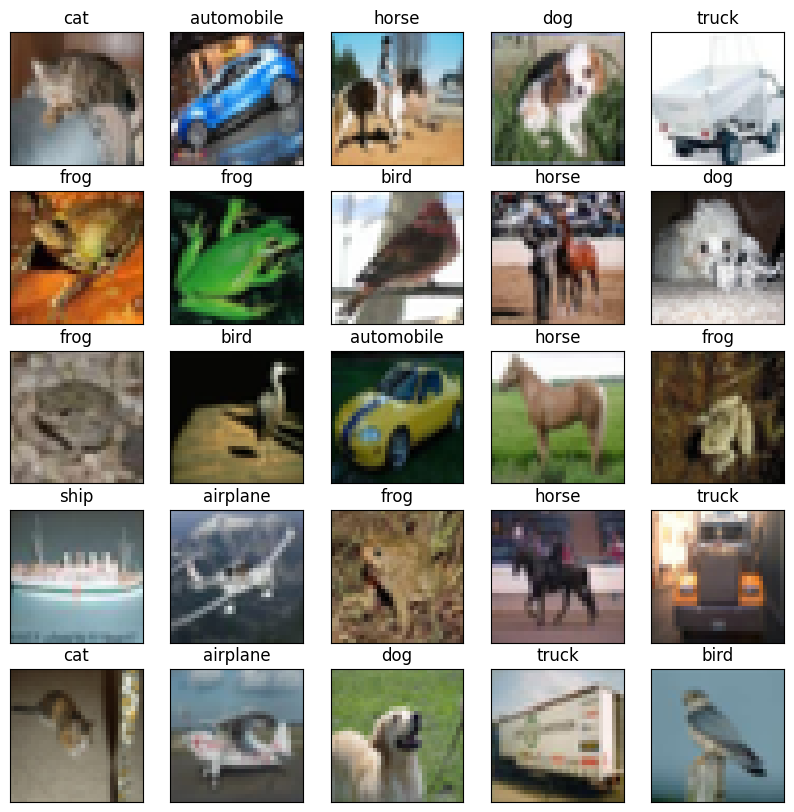

In [7]:
# Get the first batch. 
# (This may take a moment as it reads and caches the Dataset)
sample_imgs, sample_labels = train_data.as_numpy_iterator().next()

# The canvas size is first initialized by setting the parameter figsize in function plt.figure()
plt.figure(figsize=(10,10)) 
for i in range(25):
    plt.subplot(5,5,i+1)  # draw five rows and five columns in canvas
    plt.imshow(sample_imgs[i], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[np.argmax(sample_labels[i])])
plt.show()

### Building a CNN step by step

Our image-classification model is a linear stack of layers,

The `Sequential` constructor takes a list of `Layers`. As shown in the figure below, we'll use four types of layers for our CNN: convolution, max pooling, dropout, and softmax. In the example structure, one convolution layer is used. The convolution layer uses 32 *3×3* filters with stride 1 and padding, resulting in 32 *32×32* feature maps. Then, applying *2×2* max-pooling, the size of the feature maps are reduced to *16×16*. The dropout layer will randomly pass of those features to the next layer, choosing different features each time (this reduces overfitting). The features are then flattened to a vector of size 512. The vector is fed into a fully connected layer followed by a softmax layer to make predictions. 

![title](pic/cnn-diagram.png)

In [8]:
model = Sequential([
    Input(INPUT_SHAPE),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(512),
    Dense(class_num, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )


# We usually check our model by printing the model parameters through model.summary(), after defining the model.
# The model summary will show the type of model, the output of each layer and the number of parameters used by each layer.
# For example, from the input 28*28*1, through the first conv2d layer, a 26*26*8 output is obtained. 
# The number of parameters = (convolution filter size * number of channels + 1) * number of output channels.
# So, the number of parameters for this layer is (3 * 3 * 1 + 1) * 8 = 80

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,200,842 (16.02 MB)

 Trainable params: 4,200,842 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

### Training the CNN: Loss Function, Optimizer, Metrics

Before training process starts, we configure the training process, including 3 key factors during the compilation step:
1. The optimizer. Keras provides various optimizers. A good default is the Adam gradient-based optimizer. 
2. The loss function. Since we're using a Softmax output layer, the cross-Entropy loss function is used. Keras distinguishes between `binary_crossentropy` (2 classes) and `categorical_crossentropy` (>2 classes), so we'll use the latter. 
3. Metrics. The accuracy metric is used.

Note that this is the same process as in Block 1.

In [9]:
model.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Training a model in Keras is done by calling `fit()` and specifying hyper-parameters. 

Main parameters include:

1. The number of epochs (iterations of training over the entire training dataset).
2. The validation data, which is used during training to periodically measure the network's performance against the data that hasn't been seen before.

Running the following code on the full MNIST dataset gives us results.

In [10]:
history = model.fit(train_data,
    validation_data=validation_data,
    epochs=10,
         )

Epoch 1/10


I0000 00:00:1728404294.041911     141 service.cc:145] XLA service 0x709850016e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728404294.041944     141 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5


 78/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1555 - loss: 4.2919

I0000 00:00:1728404295.263145     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3579 - loss: 2.1860 - val_accuracy: 0.5164 - val_loss: 1.3748
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5299 - loss: 1.3359 - val_accuracy: 0.5640 - val_loss: 1.2512
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5703 - loss: 1.2415 - val_accuracy: 0.5614 - val_loss: 1.2588
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5856 - loss: 1.1920 - val_accuracy: 0.5862 - val_loss: 1.1993
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6060 - loss: 1.1347 - val_accuracy: 0.5926 - val_loss: 1.1728
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6179 - loss: 1.1033 - val_accuracy: 0.5970 - val_loss: 1.1578
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6211 - loss: 1.0937 - val_accuracy: 0.5972 - val_loss: 1.1489
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6247 - loss: 1.0778 - val_accuracy: 0.6286 - val_

Immediately, we can see the changes in accuracy over different epochs. We get to an validation accuracy of around 0.97 after 10 epochs. 

Recall that the Perceptron-based model from Block 1 achieved an accuracy of around 90%. The CNN model seems to work much better.

We can plot the changes in training and validation accuracy and loss as below.

<Figure size 640x480 with 0 Axes>

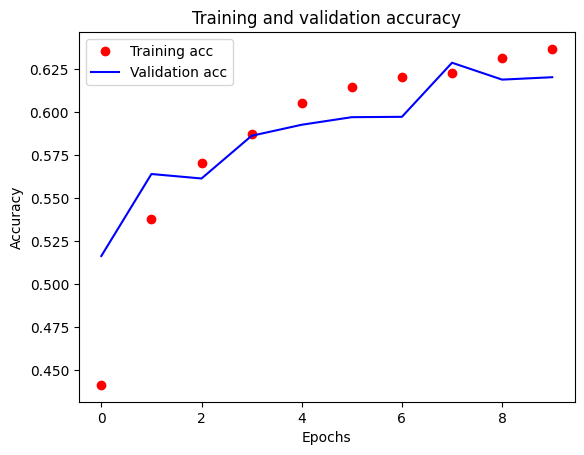

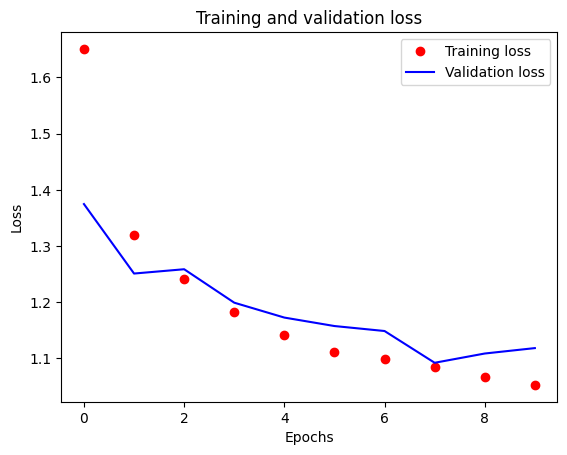

<Figure size 640x480 with 0 Axes>

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()  # Automatic detection of elements to be shown in the legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()  # Automatic detection of elements to be shown in the legend
plt.figure()

This impression is reflected in the overall accuracy and loss results. The model performs better on the validation data than the training data. Let's see what happens if we continue training for anther 10 epochs.

In [12]:
history = model.fit(train_data,
    validation_data=validation_data,
    initial_epoch=10,
    epochs=30 )

Epoch 11/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6420 - loss: 1.0382 - val_accuracy: 0.6232 - val_loss: 1.1046
Epoch 12/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6436 - loss: 1.0269 - val_accuracy: 0.6244 - val_loss: 1.0842
Epoch 13/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6477 - loss: 1.0226 - val_accuracy: 0.6354 - val_loss: 1.0654
Epoch 14/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6491 - loss: 1.0063 - val_accuracy: 0.6246 - val_loss: 1.0716
Epoch 15/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6576 - loss: 0.9896 - val_accuracy: 0.6294 - val_loss: 1.0725
Epoch 16/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6549 - loss: 0.9982 - val_accuracy: 0.6344 - val_loss: 1.0615
Epoch 17/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6568 - loss: 0.9841 - val_accuracy: 0.6072 - val_loss: 1.1585
Epoch 18/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6633 - loss: 0.9757 - val_accu

<Figure size 640x480 with 0 Axes>

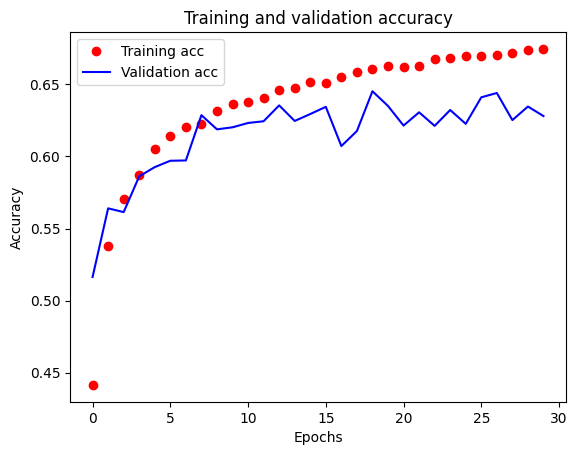

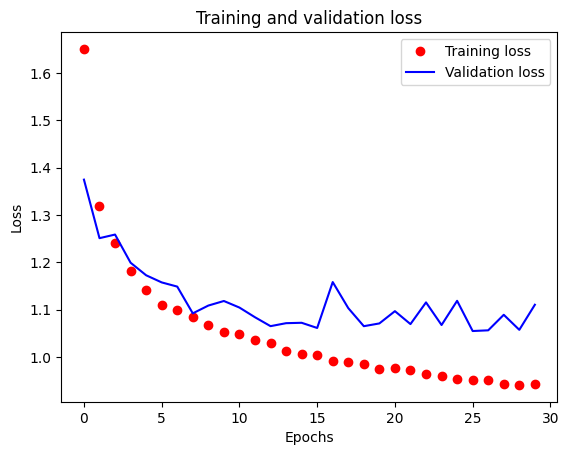

<Figure size 640x480 with 0 Axes>

In [13]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
loss += history.history['loss']
val_loss += history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

From the plots, we can see that this simple CNN structure starts to converge after 10 epochs and reaches a validation accuracy around 0.97.

### Making predictions on test data

We can now use the model to make predictions on the test data. We will:

1. use the trained model to make predictions on the test set
2. view the prediction results, and find the probabilities of the class labels to which each image belongs
3. select the label with the highest probability
4. display the correct labels and predicted labels of sample images in the test set.

Again, the process is the same as in the Block 1 notebooks.

In [14]:
test_predictions = model.predict(test_data)
test_predictions.shape

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(10000, 10)

In [15]:
test_predictions[1]

array([5.6789786e-02, 3.3998820e-01, 1.5634189e-03, 7.4124349e-05,
       3.8619524e-05, 4.1802888e-04, 3.8661919e-06, 3.3167980e-04,
       1.1279280e-02, 5.8951300e-01], dtype=float32)

In [16]:
predict_labels = np.argmax(test_predictions, axis=1)

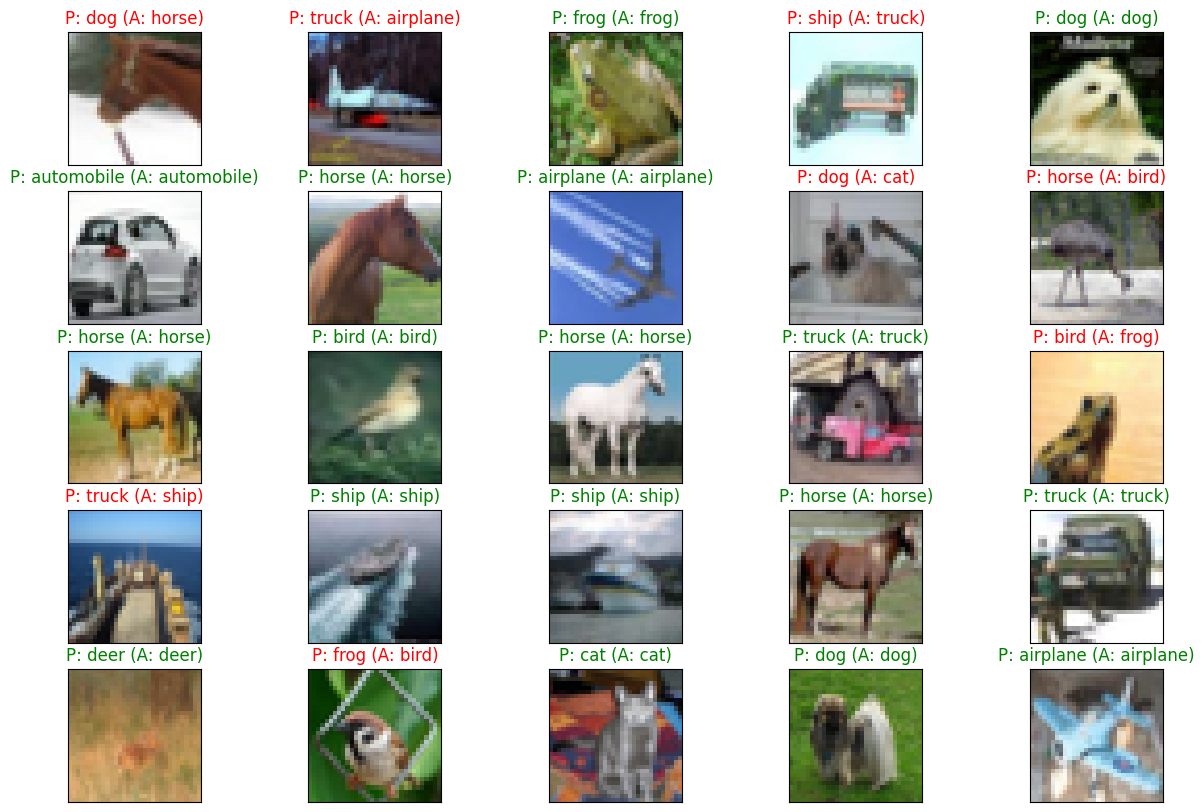

In [17]:
# View the true and predicted labels of sample images
plt.figure(figsize=(15,10))
test_imgs, test_labels = test_data.as_numpy_iterator().next()

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_imgs[i], cmap=plt.cm.binary)
    p_class = predict_labels[i]
    a_class = np.argmax(test_labels[i])
    plt.title(f"P: {class_names[p_class]} (A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()


Finally, we can evaluate the overall accuracy of the model on test data.

In [18]:
model_results = model.evaluate(test_data, return_dict=True)
model_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6355 - loss: 1.0741


{'accuracy': 0.6323000192642212, 'loss': 1.093566656112671}

So far, this simple CNN model has worked well. Now let's drill down into the model and take a closer look at what's going on at each level of our model.

### Exploring intermediate layers of the model

Note that this is new content, and a new way of looking at models and what they're doing inside. We will:

1. create an "intermediate" model, with the original input of the trained model as input and the output of the first convolutional layer of the model as output.
2. make predictions with the intermediate model.
3. view the original input.
4. look at the 8 channels generated after the input image passes through the first convolutional layer.

Now, a reminder of the model summary and different layers in the model.

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,602,528 (48.07 MB)

 Trainable params: 4,200,842 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,401,686 (32.05 MB)

In [20]:
model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Dropout name=dropout, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

Now let us create an intermediate model consisting of the original input and the first layer of the original model. 

We check the summary of the intermediate model. You can also check the layer attributes of the intermediate model and compare them with the first layer of the original model (note the address when looking at the layers attribute: you should see the same IDs after the word `at`).

In [21]:
intermediate_layer_model = keras.Model(inputs=model.inputs,
                                       outputs=model.layers[0].output)
intermediate_layer_model.summary()

intermediate_layer_model.layers

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

[<InputLayer name=input_layer, built=True>, <Conv2D name=conv2d, built=True>]

We fetch a test batch of 64 images, and show the first one.

In [22]:
test_batch, test_batch_labels = test_data.as_numpy_iterator().next()
test_batch.shape

(64, 32, 32, 3)

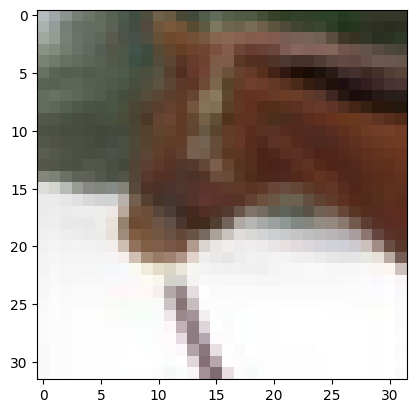

In [23]:
# ploting the original image
plt.figure()
# test_batch has a shape 64*28*28*1, here we use test_batch[0] to pick the first image, 
plt.imshow(test_batch[0]) 
# plt.savefig('./exp_pic/activity_2_figure_3.svg')

Now we can show some sample outputs of the intermediate model.

In [24]:
intermediate_output = intermediate_layer_model(test_batch)

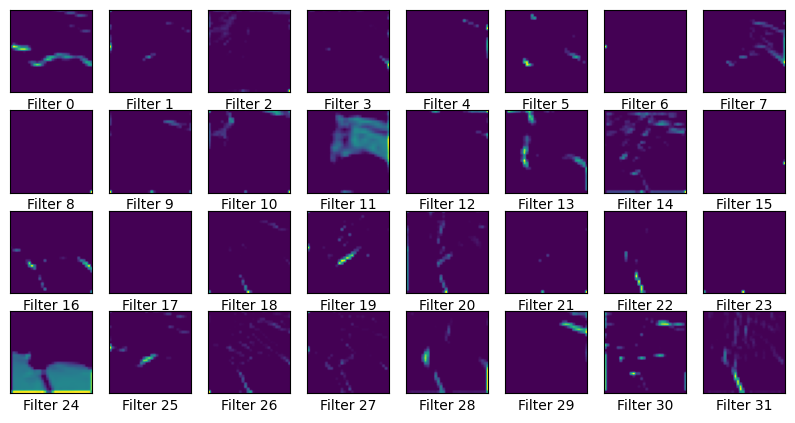

In [25]:
# Plotting the 8 intermediate feature maps generated by the 8 filters in the first convolution layer

plt.figure(figsize=(10, 5))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output[0,:,:,i]) 
    plt.xlabel(f'Filter {i}', fontsize=10)

You should see that different feature maps pick out different elements of the original image, such as horizontal, vertical, and angled lines. But exactly what features are detected will depend on how your network initialised and trained itself.

# Exercise
Examine the filter outputs for a different image in the batch.

In [26]:
# Your solution here
# Add additional cells as needed

### Example solution

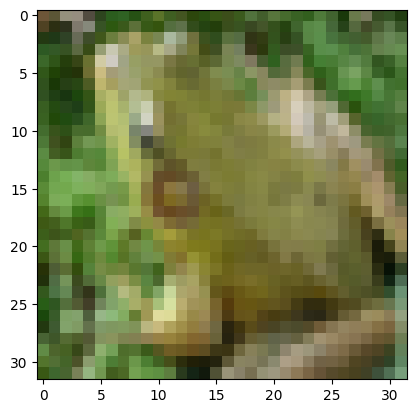

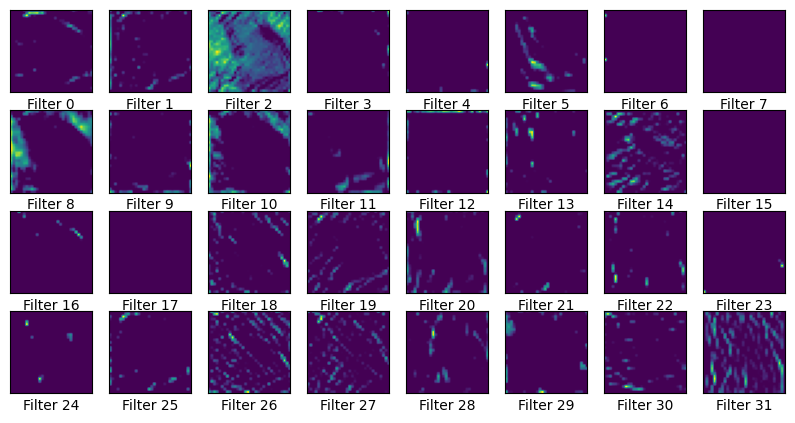

In [27]:
figure_num = 2

plt.figure()
plt.imshow(test_batch[figure_num]) 
plt.show()

plt.figure(figsize=(10, 5))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output[figure_num,:,:,i]) 
    plt.xlabel(f'Filter {i}', fontsize=10)

### End solution

Following the previous steps, let's see what happens after the first `MaxPooling` layer.

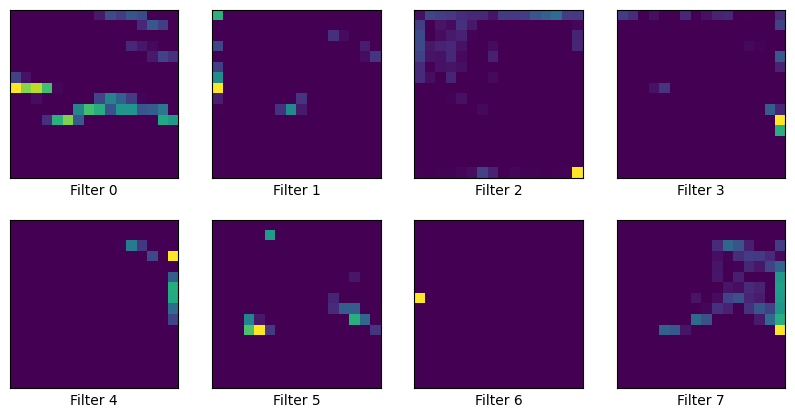

In [28]:
intermediate_layer_model = keras.Model(inputs=model.inputs,
                                       outputs=model.layers[1].output)
intermediate_output = intermediate_layer_model(test_batch)

plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output[0, :, :, i])
    plt.xlabel(f'Filter {i}', fontsize=10)

You should see that the max pooling layer gives a "lower-resolution image" of the corresponding filter. 

Let's continue to explore the output of the second convolutional layer and the output of the second max pooling layer.

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

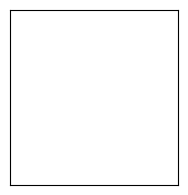

In [30]:
intermediate_layer_model = keras.Model(inputs=model.inputs,
                                       outputs=model.layers[3].output)
intermediate_output = intermediate_layer_model(test_batch)

plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output[0,:,:,i])
    plt.xlabel(f'Filter {i}', fontsize=10)

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

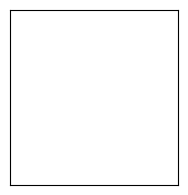

In [31]:
intermediate_layer_model = keras.Model(inputs=model.inputs,
                                       outputs=model.layers[4].output)
intermediate_output = intermediate_layer_model(test_batch)

plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output[0,:,:,i])
    plt.xlabel(f'Filter {i}', fontsize=10)

# Exercise

In [35]:
model3 = Sequential([
    Input((32, 32, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(class_num, activation='softmax')
])

model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [36]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,890 (370.66 KB)

 Trainable params: 94,890 (370.66 KB)

 Non-trainable params: 0 (0.00 B)

<Figure size 640x480 with 0 Axes>

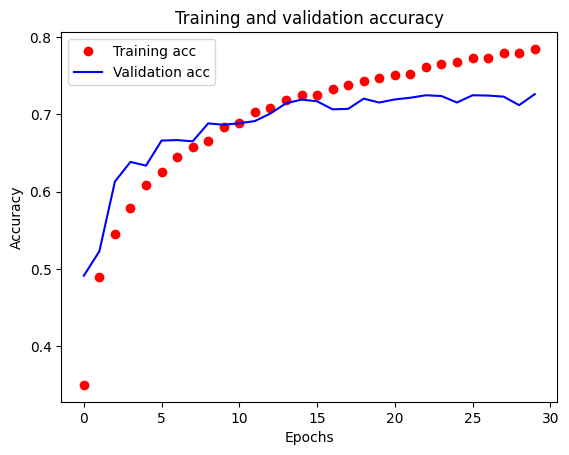

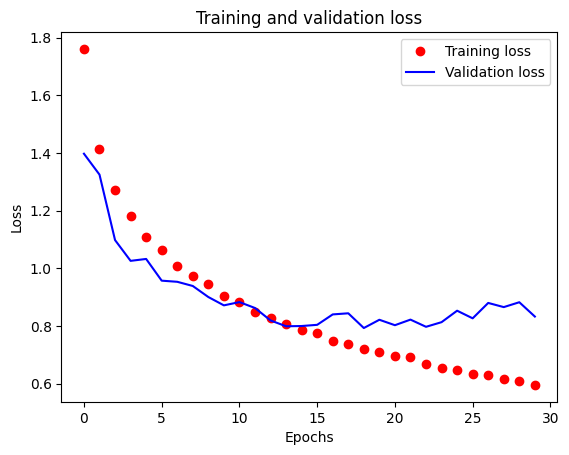

<Figure size 640x480 with 0 Axes>

In [37]:
history = model3.fit(train_data,
    validation_data=validation_data,
    epochs=30,
    verbose=0
         )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

In [39]:
model3_results = model3.evaluate(test_data, return_dict=True)
model3_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7393 - loss: 0.8373


{'accuracy': 0.7383999824523926, 'loss': 0.8366618752479553}

In [40]:
list(enumerate(model3.layers))

[(0, <Conv2D name=conv2d_4, built=True>),
 (1, <MaxPooling2D name=max_pooling2d_4, built=True>),
 (2, <Conv2D name=conv2d_5, built=True>),
 (3, <MaxPooling2D name=max_pooling2d_5, built=True>),
 (4, <Conv2D name=conv2d_6, built=True>),
 (5, <MaxPooling2D name=max_pooling2d_6, built=True>),
 (6, <Flatten name=flatten_2, built=True>),
 (7, <Dense name=dense_4, built=True>),
 (8, <Dropout name=dropout_2, built=True>),
 (9, <Dense name=dense_5, built=True>)]

Now let us create an intermediate model consisting of the original input and the first layer of the original model. 

We check the summary of the intermediate model. You can also check the layer attributes of the intermediate model and compare them with the first layer of the original model (note the address when looking at the layers attribute: you should see the same IDs after the word `at`).

In [41]:
intermediate_layer_model = keras.Model(inputs=model3.inputs,
                                       outputs=model3.layers[0].output)
intermediate_layer_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

We fetch a test batch of 64 images, and show the first one.

In [42]:
test_batch, test_batch_labels = test_data.as_numpy_iterator().next()
test_batch.shape

(64, 32, 32, 3)

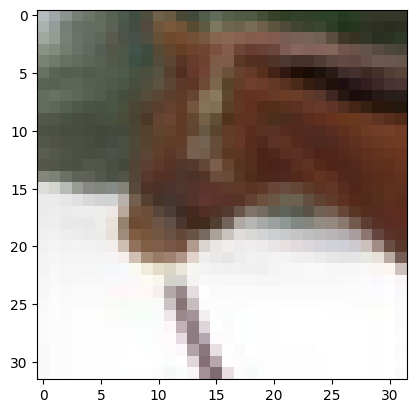

In [43]:
# ploting the original image
plt.figure()
# test_batch has a shape 64*28*28*1, here we use test_batch[0] to pick the first image, 
plt.imshow(test_batch[0]) 
# plt.savefig('./exp_pic/activity_2_figure_3.svg')

Now we can show some sample outputs of the intermediate model.

In [44]:
intermediate_output = intermediate_layer_model(test_batch)

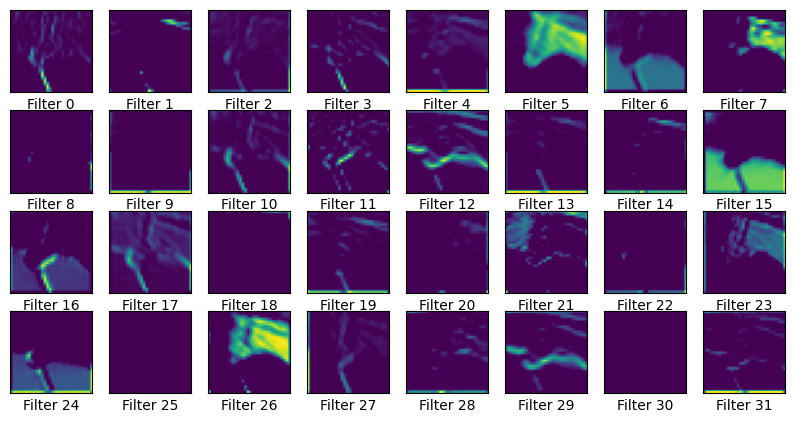

In [45]:
# Plotting the 8 intermediate feature maps generated by the 8 filters in the first convolution layer

plt.figure(figsize=(10, 5))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output[0,:,:,i]) 
    plt.xlabel(f'Filter {i}', fontsize=10)

In [46]:
intermediate_layer_model2 = keras.Model(inputs=model3.inputs,
                                       outputs=model3.layers[2].output)
intermediate_layer_model2.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,144 (39.62 KB)

 Trainable params: 10,144 (39.62 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
intermediate_output2 = intermediate_layer_model2(test_batch)

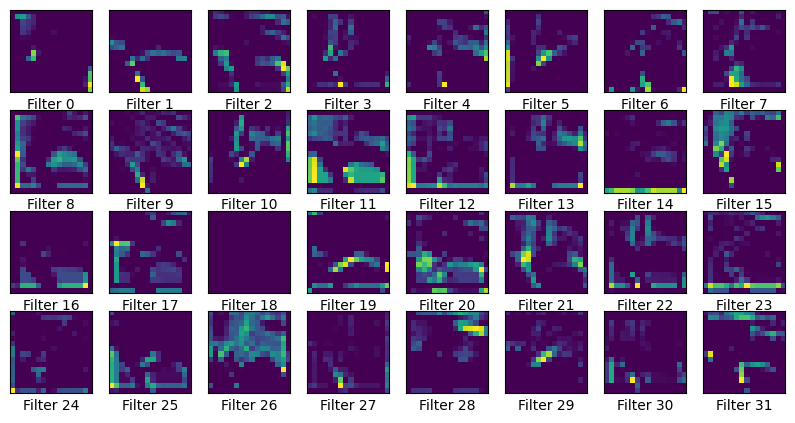

In [48]:
# Plotting the 8 intermediate feature maps generated by the 8 filters in the first convolution layer

plt.figure(figsize=(10, 5))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output2[0,:,:,i]) 
    plt.xlabel(f'Filter {i}', fontsize=10)

# Conclusion

You can further explore CNN by creating one or two your own models. For example, you may see how the performance changes if you remove the max-pooling layers and dropout layers; or if you change the number of filters, e.g., to 4. 